In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

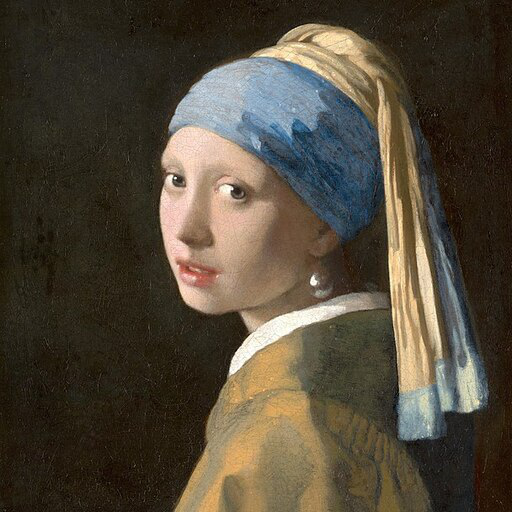

In [3]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

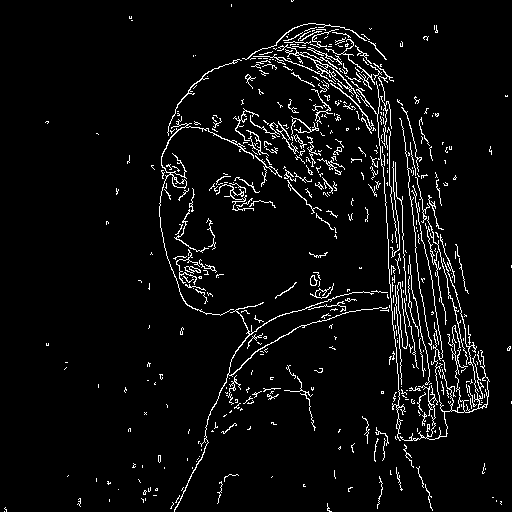

In [4]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

In [5]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

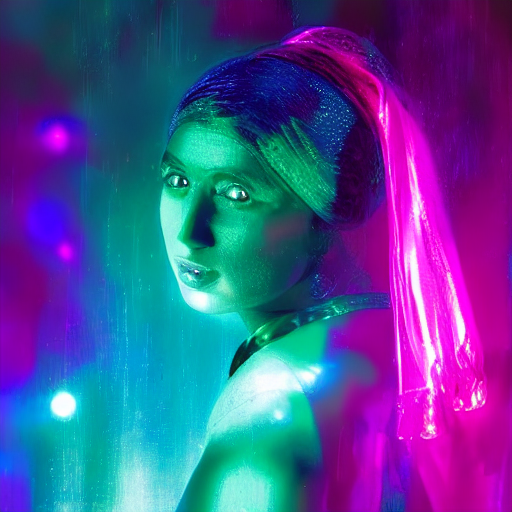

In [6]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

In [7]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

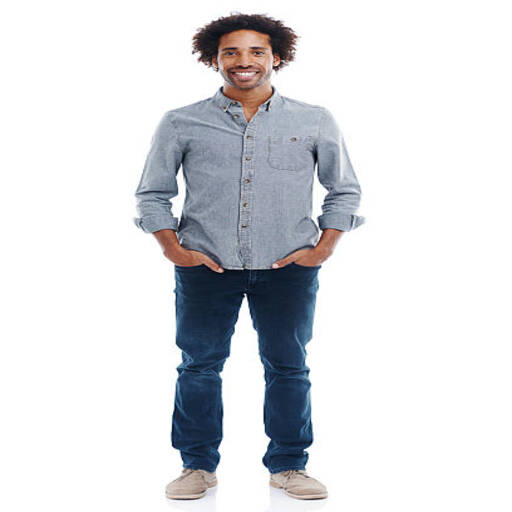

In [8]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


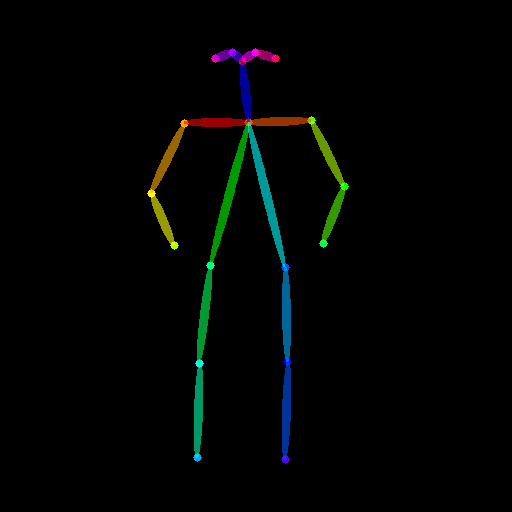

In [9]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [10]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/10 [00:00<?, ?it/s]

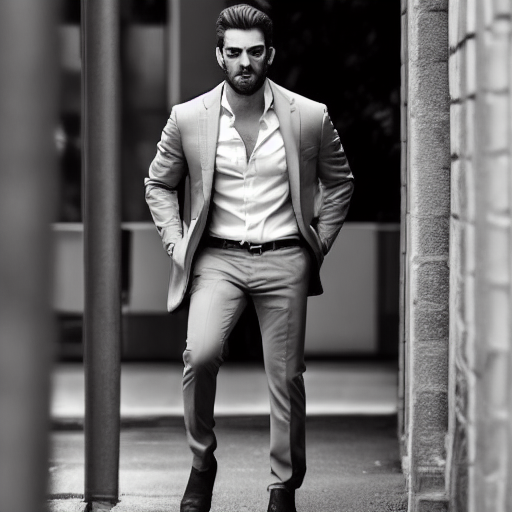

In [17]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(0)

#프롬프트를 작성합니다. 
prompt =  'handsome man'
negative_prompt =  'white'

images = openpose_image

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(
    prompt=prompt,
    num_inference_steps=10,
    generator=generator,
    image=images
).images[0]

openpose_image1.save("/aiffel/openpose_image.png")

# 생성된 이미지를 출력합니다. 
openpose_image1

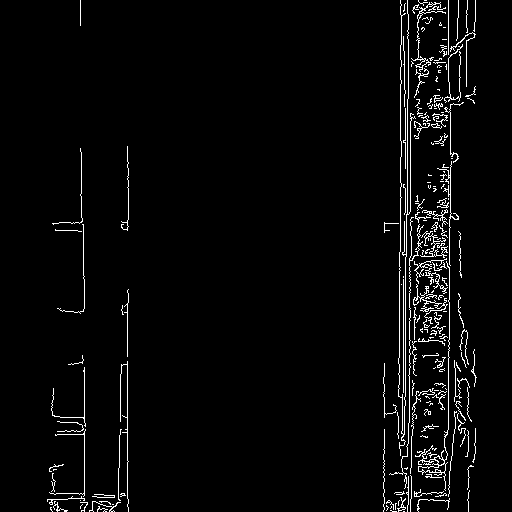

In [18]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요. 
image_path = "/aiffel/openpose_image.png"
canny_image = Image.open(image_path)

#threshhold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. 
canny_image = np.array(canny_image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

canny_image

cuda


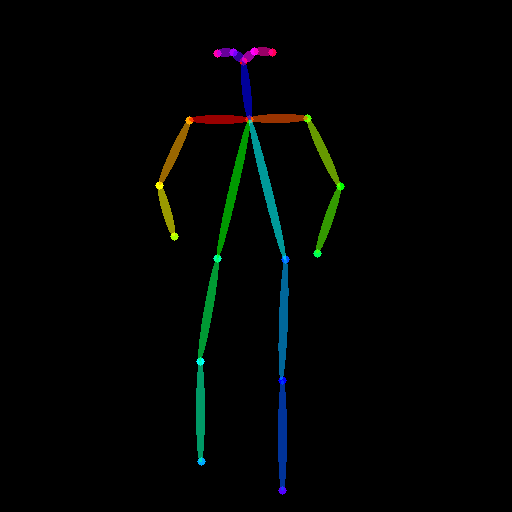

In [20]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다. 
image_path = "/aiffel/openpose_image.png"
openpose_image = Image.open(image_path)

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

openpose_image

In [38]:
# 메모리 삭제
torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

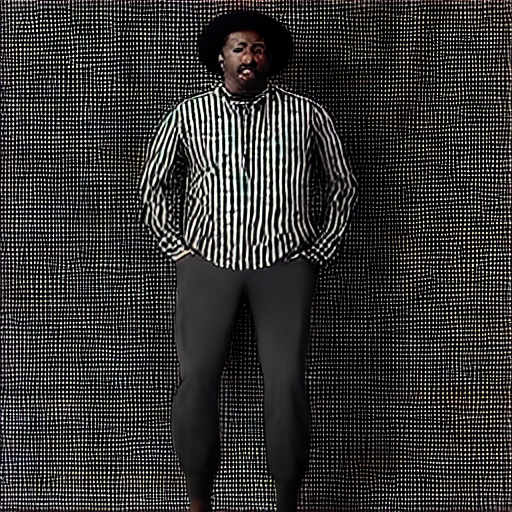

In [39]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
edge_detection = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [edge_detection, openpose]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt =  'black man'
negative_prompt =  'white'

# seed를 지정합니다. 
generator = torch.manual_seed(0)

images = [openpose_image, canny_image]

# 이미지를 생성합니다. 
image = pipe(prompt=prompt, negative_prompt=negative_prompt, generator=generator, image=images).images[0]

# 생성된 이미지를 저장합니다.
image.save("aiffel/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.  
image